# Unsupervised Anomaly Detection

We continue with anomaly detection by focusing now on unsupervised anomaly detection. Recall, you can think of an anomaly as some sort of highly unusual event occuring in your data that you wish to find (e.g. an attack on your network, a defective device, credit card fraud). More usefully, a good definition of an anomaly is the following: An anomaly is a data sample that deviates significantly from other data samples, so much so to suggest that it was generated by a different mechanism. In probability language, you can think of an anomaly as something that comes from a different distribution than the "real" data.

Unsupervised anomaly detection deals with the case where we don't know ahead of time which points in our dataset are anomalies. The goal is to figure out what the structure of the data is, and to use that structure to try to determine what the anomalies are. In statistical lingo this is often called _outlier detection_. We're looking for points that look statistically unusual in some way.

In [284]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
np.random.seed(4)

import warnings
warnings.filterwarnings('ignore')

In [285]:
def get_data(size=1000,ratio=0.01):
    num_neg_samples = round(size*(1-ratio))
    num_pos_samples = round(size*ratio)
    X_neg = np.random.multivariate_normal(np.array([0,0]),.5*np.eye(2),size=num_neg_samples)
    #X_neg = np.vstack([np.random.multivariate_normal(np.array([2.5,0]),.5*np.eye(2),size=num_neg_samples//2),
    #                  np.random.multivariate_normal(np.array([-2.5,0]),np.random.rand(2,2),size=num_neg_samples//2)])
    y_neg = np.ones(len(X_neg))
    X_pos = get_pos_samples(num_pos_samples)
    y_pos = -1*np.ones(len(X_pos))
    X = np.vstack([X_neg,X_pos])
    y = np.concatenate([y_neg,y_pos])
    idx = np.random.permutation(len(y))
    X = X[idx]
    y = y[idx]
    return X,y

def get_pos_samples(n,lim=3):
    # generates anomalies from a mixture distribution
    # consists of 1 U(-lim,lim) + 3 N(mean,cov) with random means and covs
    x = np.zeros((n,2))
    idx = np.arange(n)
    
    mean = np.random.uniform(-lim,lim,size=2)
    cov = .05*np.random.rand()*np.eye(2)
    for i in idx[:n//2]:
        x[i] = np.random.multivariate_normal(mean,cov,size=1)

    mean = np.random.uniform(-lim,lim,size=2)
    cov = .01*np.random.rand()*np.eye(2)
    for i in idx[n//2:]:
        x[i] = np.random.multivariate_normal(mean,cov,size=1)

    #mean = np.random.uniform(-lim,lim,size=2)
    #cov = .01*np.random.rand()*np.eye(2)
    #for i in idx[2*n//3:]:
    #    x[i] = np.random.multivariate_normal(mean,cov,size=1)

    u = np.zeros((5,2))
    for i in range(5):
        u[i] = np.random.uniform(-lim+1,lim+1,size=2)

    z = np.zeros((2,2))    
        
    return np.vstack([x,u,z])

def plot_data(X,y,yhat=None):
    lim = np.max(np.abs(X))
    f, ax = plt.subplots(figsize=(8, 8))    
    ax.scatter(X[y==1][:,0],X[y==1][:,1],marker='.',c='blue',s=10,alpha=0.5,label='normal data')
    ax.scatter(X[y==-1][:,0],X[y==-1][:,1],marker='.',c='red',s=50,label='anomalies')
    if yhat is not None:
        ax.scatter(X[yhat==-1][:,0],X[yhat==-1][:,1],marker='.',c='green',s=50,label='predicted anomalies')
    ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
    ax.legend(loc='upper right')
    plt.xlim(-lim-.5,lim+.5)
    plt.ylim(-lim-.5,lim+.5)
    plt.show()
    
def get_scores(y,yhat):
    print('f1: ', round(f1_score(y,yhat),4))
    print('number of anomalies found:',(yhat[y==-1] == y[y==-1]).sum(),'out of',len(y[y==-1]))
    print('confusion matrix:\n', confusion_matrix(y,yhat))

Number of non-anomalies: 1485
Number of anomalies: 22
Percent anomalies in dataset: 1.46 %


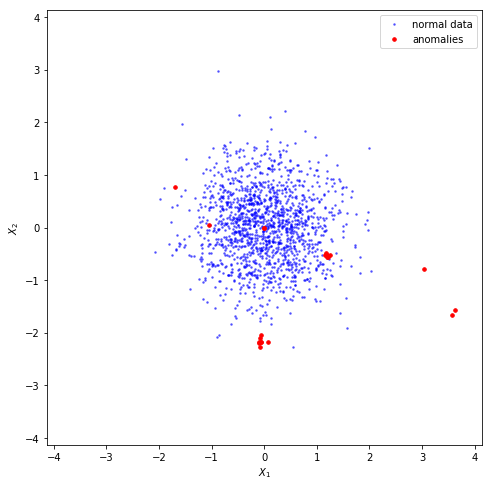

In [286]:
X,y = get_data(1500,0.01)
print('Number of non-anomalies:',len(y[y==1]))
print('Number of anomalies:',len(y[y==-1]))
print('Percent anomalies in dataset:',round(len(y[y==-1])/(len(y[y==1])+len(y[y==-1]))*100,2),'%')
plot_data(X,y)

f1:  0.9916
number of anomalies found: 10 out of 22
confusion matrix:
 [[  10   12]
 [  13 1472]]


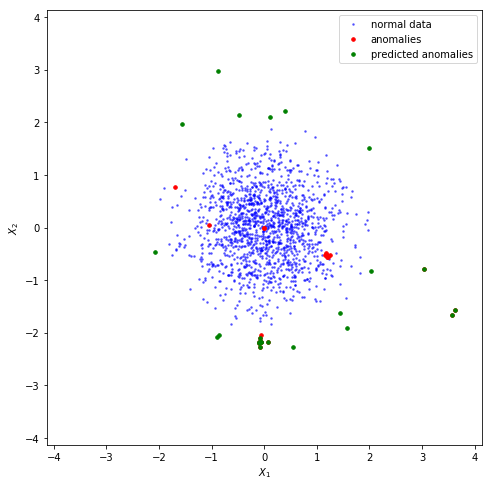

In [287]:
model = EllipticEnvelope(contamination=0.015)
model.fit(X)
yhat = model.predict(X)

get_scores(y,yhat)
plot_data(X,y,yhat)

f1:  0.9902
number of anomalies found: 8 out of 22
confusion matrix:
 [[   8   14]
 [  15 1470]]


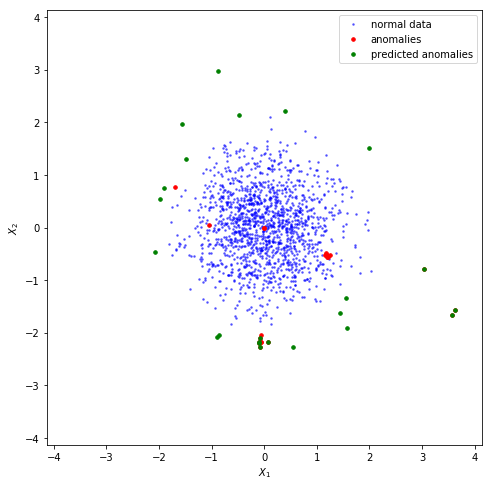

In [288]:
model = IsolationForest(contamination=0.015)
model.fit(X)
yhat = model.predict(X)

get_scores(y,yhat)
plot_data(X,y,yhat)

f1:  0.9472
number of anomalies found: 12 out of 22
confusion matrix:
 [[  12   10]
 [ 140 1345]]


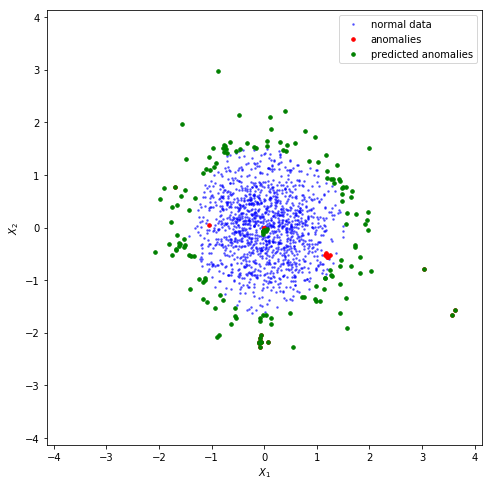

In [289]:
model = OneClassSVM(nu=0.1)
model.fit(X)
yhat = model.predict(X)

get_scores(y,yhat)
plot_data(X,y,yhat)

f1:  0.9916
number of anomalies found: 10 out of 22
confusion matrix:
 [[  10   12]
 [  13 1472]]


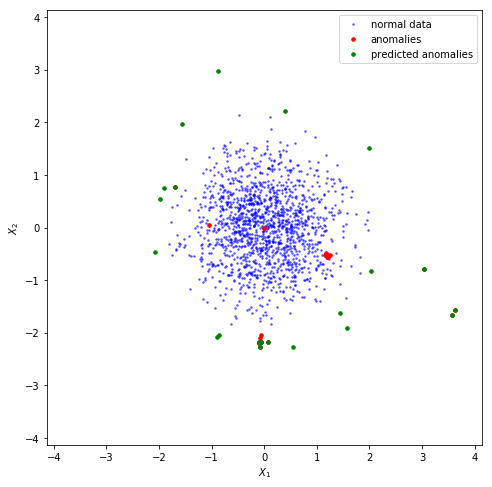

In [290]:
model = LocalOutlierFactor(n_neighbors=80,contamination=0.015,n_jobs=-1)
yhat = model.fit_predict(X)

get_scores(y,yhat)
plot_data(X,y,yhat)

f1:  0.9815
number of anomalies found: 22 out of 22
confusion matrix:
 [[  22    0]
 [  54 1431]]


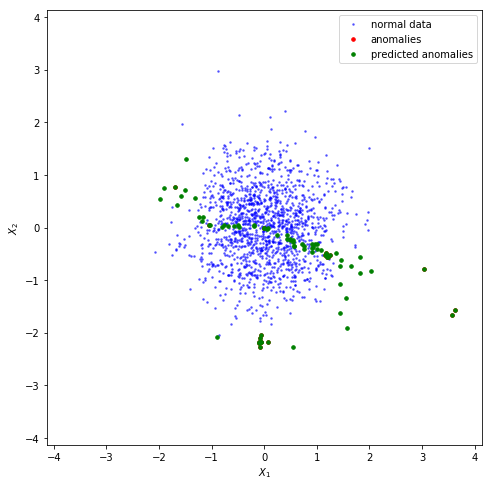

In [291]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
X_train_bal,y_train_bal = SMOTE().fit_sample(X_train,y_train)

model = RandomForestClassifier(min_samples_leaf=5, n_jobs=-1)
model.fit(X_train_bal,y_train_bal)

yhat = model.predict(X)
get_scores(y,yhat)
plot_data(X,y,yhat)